## Normal Double Q vs normal Q

In [1]:
NAMES = "Jan Huiskes, Eli de Smet"

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [3]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

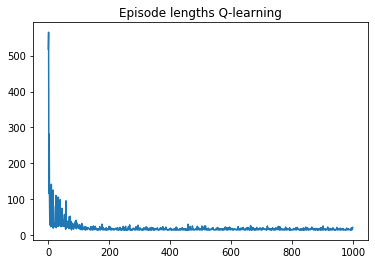

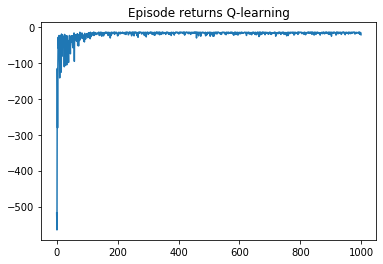

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    pol_greed = make_epsilon_greedy_policy(Q, 0, env.action_space.n)
    
    for i_episode in range(num_episodes):
        i = 0
        R = 0
        
        s = env.reset()
#         a = policy(s) # dit heb ik weggehaald
        while True:
            a = policy(s) # dit heb ik toegevoegd
            s_next, reward, done, _ = env.step(a)
            i += 1
            R += reward
            
            if done:
                break
            
            a_next = pol_greed(s_next)
            
            Q[s][a] = alpha * (reward + discount_factor * Q[s_next][a_next] - Q[s][a]) + Q[s][a]
            s = s_next
#             a = a_next # dit heb ik weggehaald
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

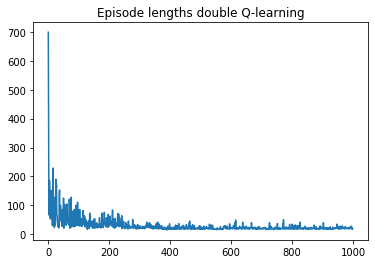

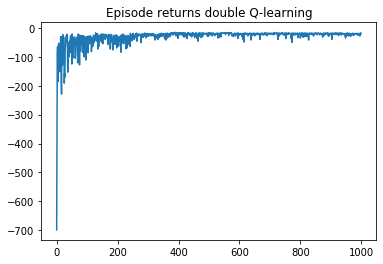

In [6]:
def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    # Q1, Q2, and one combined for eps greedy policy
    if Q is None:
        Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
        Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
        combined_Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following based on combined Q values
    policy = make_epsilon_greedy_policy(combined_Q, epsilon, env.action_space.n)
    
    # Different greedy policies
    pol_greed_1 = make_epsilon_greedy_policy(Q1, 0, env.action_space.n)
    pol_greed_2 = make_epsilon_greedy_policy(Q2, 0, env.action_space.n)

    for i_episode in range(num_episodes):
        i = 0
        R = 0
        
        s = env.reset()
        while True:
            a = policy(s) 
            s_next, reward, done, _ = env.step(a)
            i += 1
            R += reward
            
            if done:
                break
            # Random pick one, update and update the combined Dictionary
            if np.random.uniform() < 0.5:
                a_next = pol_greed_2(s_next)
                Q2[s][a] = alpha * (reward + discount_factor * Q1[s_next][a_next] - Q2[s][a]) + Q2[s][a]
                combined_Q[s][a] = alpha * (reward + discount_factor * combined_Q[s_next][a_next] - combined_Q[s][a]) + combined_Q[s][a]
                s = s_next
            else:
                a_next = pol_greed_1(s_next)
                Q1[s][a] = alpha * (reward + discount_factor * Q2[s_next][a_next] - Q1[s][a]) + Q1[s][a]
                combined_Q[s][a] = alpha * (reward + discount_factor * combined_Q[s_next][a_next] - combined_Q[s][a]) + combined_Q[s][a]
                s = s_next
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_double_q_learning)
plt.title('Episode lengths double Q-learning')
plt.show()
plt.plot(episode_returns_double_q_learning)
plt.title('Episode returns double Q-learning')
plt.show()

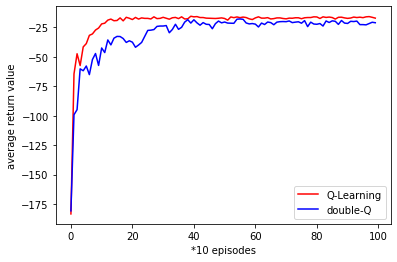

In [7]:
# Plot better overview
avg_rewards_q_learn = np.array(episode_returns_q_learning).reshape(-1, 10).mean(1)
avg_rewards_sarsa = np.array(episode_returns_double_q_learning).reshape(-1, 10).mean(1)

plt.plot(avg_rewards_q_learn, color='r', label='Q-Learning')
plt.plot(avg_rewards_sarsa, color='b', label='double-Q')
plt.legend()
plt.xlabel('*10 episodes')
plt.ylabel('average return value')
plt.show()

0
10
20
30
40
50
60
70
80
90


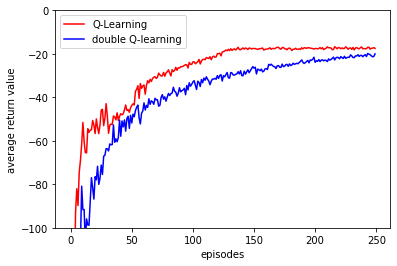

In [8]:
## ugly, ugly sampling and averaging
# Double Q is worse in this Case!

n_samples = 100

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 250)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 250)

total_q_learning = np.array(episode_returns_q_learning)
total_double = np.array(episode_returns_double_q_learning)
for i in range(n_samples-1):
    Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 250)
    Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 250)
    total_q_learning += episode_returns_q_learning
    total_double += episode_returns_double_q_learning
    if i%10 == 0:
        print(i)
avg_rewards_q_learn = np.array(total_q_learning)/n_samples
avg_rewards_double = np.array(total_double) / n_samples

plt.plot(avg_rewards_q_learn, color='r', label='Q-Learning')
plt.plot(avg_rewards_double, color='b', label='double Q-learning')
plt.ylim(-100, 0)
plt.legend()
plt.xlabel('episodes')
plt.ylabel('average return value')
plt.show()

## Deep double Q

In [9]:
import gym
env = gym.envs.make("CartPole-v0")
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

In [23]:
## The Q network
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        # YOUR CODE HERE
        x = self.l1(x)
        x= torch.relu(x)
        x = self.l2(x)
        
        return x
    
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            del self.memory[0]
        self.memory.append(transition)

    def sample(self, batch_size):
        sample = random.sample(self.memory, batch_size)
        return sample
    
    def __len__(self):
        return len(self.memory)

# THIS IS VERY IMPORTANT
def get_epsilon(it):
    if it < 2000:
        return 1 - 0.95 * it / 2000
    else:
        return 0.02
    
def get_epsilon2(it):
    if it < 2000:
        return 1 - 0.95 * it / 2000
    else:
        return 0.02
    
    
def select_action(model, state, epsilon):
    with torch.no_grad():
        actions = model(torch.FloatTensor(state))
    actions = actions.numpy()
    return int(np.random.rand() * len(actions)) if np.random.rand() < epsilon else np.argmax(actions)


### DQN (normal)

In [24]:
def compute_q_val(model, state, action):
    Qval = model(torch.FloatTensor(state))
    return torch.gather(Qval, 1, action.unsqueeze(-1)).reshape(-1)
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    Qval = model(torch.FloatTensor(next_state))
    target = reward + discount_factor * Qval.max(1)[0] * (1- done.float())
    
    return target

def train(model, memory, optimizer, batch_size, discount_factor):    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        episode = 0
        s = env.reset()
        while True:
            eps = get_epsilon(global_steps)
            action = select_action(model, s, eps)

            next_state, reward, done, _ = env.step(action)
            episode += 1
            
            memory.push((s, action, reward, next_state, done))
            
            train(model, memory, optimizer, batch_size, discount_factor)

            global_steps += 1
            
            if done: 
                break
                
            s = next_state
        episode_durations.append(episode)   
    return episode_durations


In [25]:
# Let's run it!
num_episodes = 150
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

### Double DQN

In [26]:

def compute_q_val_double(model, target, state, action):
    Qval = model(torch.FloatTensor(state))
    Qval2 = target(torch.FloatTensor(state))
    return torch.gather(Qval, 1, action.unsqueeze(-1)).reshape(-1), torch.gather(Qval2, 1, action.unsqueeze(-1)).reshape(-1)
    
def compute_target_double(model, target, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    next_Q1 = model(torch.FloatTensor(next_state))
    next_Q2 = target(torch.FloatTensor(next_state))
    next_Q = torch.min(
        torch.max(next_Q1, 1)[0],
        torch.max(next_Q2, 1)[0]
    )
    next_Q = next_Q.view(next_Q.size(0), 1)
    expected_Q = reward + discount_factor * next_Q.max(1)[0] * (1- done.float())
    
    return expected_Q

def train_double(model, target, memory, optimizer,optimizer2, batch_size, discount_factor):
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val, q_val2 = compute_q_val_double(model, target, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        expected_Q = compute_target_double(model, target, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss1 = F.mse_loss(q_val, expected_Q)

    loss2 = F.mse_loss(q_val2, expected_Q)
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    return loss1.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes_double(train, model,target, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer1 = optim.Adam(model.parameters(), learn_rate)
    optimizer2 = optim.Adam(target.parameters(), learn_rate)
  
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        episode = 0
        s = env.reset()
        while True:
            eps = get_epsilon2(global_steps)
            action = select_action(model, s, eps)

            next_state, reward, done, _ = env.step(action)
            # TODO: is it correct to compute duration here and not after the break?
            episode += 1
            
            memory.push((s, action, reward, next_state, done))
            
            train_double(model, target, memory, optimizer1, optimizer2, batch_size, discount_factor)

            global_steps += 1
            
            if done: 
                break
                
            s = next_state
        episode_durations.append(episode)   
    return episode_durations

In [27]:
# Let's run it!
num_episodes = 150
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)
target = QNetwork(num_hidden)

episode_durations_double = run_episodes_double(train, model, target, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

Text(0.5, 1.0, 'Episode durations per episode')

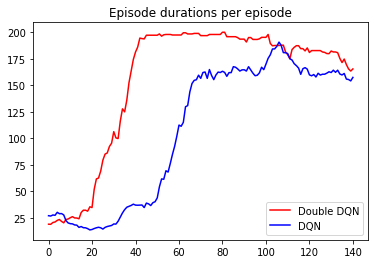

In [28]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations_double, 10),color='r', label='Double DQN')
plt.plot(smooth(episode_durations, 10),color='b', label='DQN')
plt.legend()

plt.title('Episode durations per episode')

### References

In [16]:
# https://towardsdatascience.com/double-deep-q-networks-905dd8325412
# https://arxiv.org/pdf/1802.09477.pdf